## Introduction
Pizza! 

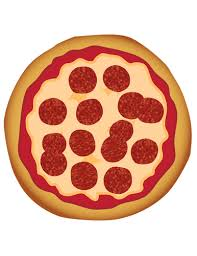 

## Exploratory Analysis
To begin this exploratory analysis, first import libraries and define functions for plotting the data using `matplotlib`. Depending on the data, not all plots will be made. (Hey, I'm just a simple kerneling bot, not a Kaggle Competitions Grandmaster!)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
import warnings


%matplotlib inline




There is 1 csv file in the current version of the dataset:


In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


The next hidden code cells define functions for plotting data. Click on the "Code" button in the published kernel to reveal the hidden code.

In [ ]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    #df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            sns.distplot(columnDf)
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = sns.heatmap(corr,annot=True,cmap="PuBu",center=1)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()
    


In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


Now you're ready to read in the data and use the plotting functions to visualize the data.

### Let's check 1st file: /kaggle/input/Pizza.csv

In [ ]:
nRowsRead = None # specify 'None' if want to read whole file
# Pizza.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
pizza_data = pd.read_csv('/kaggle/input/Pizza.csv', delimiter=',', nrows = nRowsRead, index_col = 'id')
pizza_data.dataframeName = 'Pizza.csv'
nRow, nCol = pizza_data.shape
print(f'There are {nRow} rows and {nCol} columns')

Let's take a quick look at what the data looks like:

In [ ]:
pizza_data.head(5)


Distribution graphs (histogram/bar graph) of sampled columns:

In [ ]:
plotPerColumnDistribution(pizza_data, 10, 5)

Correlation matrix:

In [ ]:
plotCorrelationMatrix(pizza_data, 8)

Scatter and density plots:

In [ ]:
plotScatterMatrix(pizza_data, 20, 10)

# Info about the data

In [ ]:
pizza_data.info()
pizza_data.isnull().sum()

## Relationship between moisture and other attributes



In [ ]:
features = ['brand', 'prot', 'fat', 'ash', 'sodium', 'carb', 'cal']
X = pizza_data[features]
y = pizza_data['mois']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Apply one-hot encoder to brand
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[['brand']]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[['brand']]))

# put index back
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

# add column names
OH_cols_train.columns = OH_encoder.get_feature_names()
OH_cols_test.columns = OH_encoder.get_feature_names()


# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(['brand'], axis=1)
num_X_test = X_test.drop(['brand'], axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)


# predictions using One Hot Encoder
warnings.filterwarnings("ignore")
my_model1 = RandomForestRegressor(random_state=1)
my_model1.fit(OH_X_train, y_train)
preds1 = my_model1.predict(OH_X_test)
print("MAE with one hot encocer: " + str(mean_absolute_error(y_test, preds1)))

my_model2 = RandomForestRegressor(random_state=1)
my_model2.fit(num_X_train, y_train)
preds2 = my_model2.predict(num_X_test)
print("MAE with numerical columns only: " + str(mean_absolute_error(y_test, preds2)))



print('Done')

## Feature importance

In [ ]:
feature_importances_ohe = pd.DataFrame({'Feature': OH_X_train.columns, 'Importance': my_model1.feature_importances_})
feature_importances_ohe.set_index('Feature', inplace=True)
feature_importances_ohe.plot.bar(title='Feature importance with One Hot Encoder')

feature_importances_num = pd.DataFrame({'Feature': num_X_train.columns, 'Importance': my_model2.feature_importances_})
feature_importances_num.set_index('Feature', inplace=True)
feature_importances_num.plot.bar(title='Feature importance with numerical columns only')


plt.show()

## Predictions vs Actual values

In [ ]:
df_diff = pd.DataFrame({'Actual': y_test, 'Predicted_ohe': preds1, 'Predicted_num': preds2})

plt.figure(figsize=(10,10))
plt.plot(preds1, y_test,'bx',markersize=10)
plt.plot(preds2, y_test,'r+',markersize=10)
plt.title('Error analysis')
plt.xlabel('Predicted values')
plt.ylabel('Test values')

## Conclusion
Moisture content depends heavily on calories (although I'm not a food scientist and I have no clue what I'm doing.)